In [2]:
from typing import *
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from mtcnn import MTCNN
from skimage.feature import hog, local_binary_pattern
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV, KFold
import re


Carreguem imatges i classes del nostre dataset. Utilitzem el mètode MTCNN que utilitza xarxes neuronals per detectar la cara. 

In [3]:
def load_dataset(dataset_path):
    data = []
    labels = []
    names = []
    characters = os.listdir(dataset_path) 
    label_map = {character: idx for idx, character in enumerate(characters)}
    
    for character in characters:
        character_path = os.path.join(dataset_path, character)
        images = os.listdir(character_path)
        
        for img_name in images:
            img_path = os.path.join(character_path, img_name)
            img = Image.open(img_path).convert("RGB")
            image_array = np.array(img)
            faces = MTCNN().detect_faces(image_array)

            if len(faces) > 0:
                x1, y1, amplada, altura = faces[0]['box']
                x2, y2 = x1 + amplada , y1 + altura
                face = image_array[y1:y2, x1:x2]
                image = Image.fromarray(face)
                data.append(image)
                labels.append(label_map[character])
                names.append(character)
            
            # Si no es detecta ninguna cara,  no ens guardem la imatge
            else:
                print(f"No s'ha detectat cara a la imatge {img_path}")
    
    return data, labels, names

In [4]:
data, labels, names = load_dataset(dataset_path="C:/Users/nerea/OneDrive/Escritorio/cosas uni/3r/AP/kaggle/CastHP")

No s'ha detectat cara a la imatge C:/Users/nerea/OneDrive/Escritorio/cosas uni/3r/AP/kaggle/CastHP\Albus Dumbledore\Micheal Gambon (11).jpg
No s'ha detectat cara a la imatge C:/Users/nerea/OneDrive/Escritorio/cosas uni/3r/AP/kaggle/CastHP\Severus Snape\Alan Rickman (12).jpg


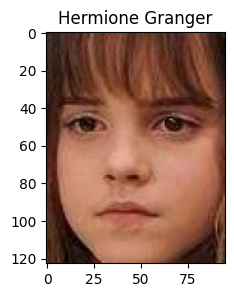

Etiqueta de la imatge: 5


In [5]:
plt.figure(figsize=(3,3))
plt.imshow(data[257])
plt.title(names[257])
plt.show()
print("Etiqueta de la imatge:", labels[257])

Fem un preprocessament de les imatges, redimensionant les imatges per que tinguin el mateix tamany i les carreguem en escala de grisos per reducir la dimensionalitat:

Text(0.5, 1.0, 'Hermione Granger')

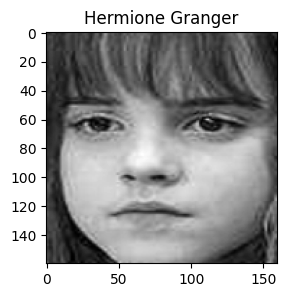

In [6]:
def preprocess_images(images, size):
    preprocessed = []
    for img in images:
        img_resized = img.resize(size)
        img_gray = cv2.cvtColor(np.array(img_resized), cv2.COLOR_BGR2GRAY)
        preprocessed.append(np.array(img_gray))
    return preprocessed

data_preprocessed = preprocess_images(data, (160, 160))
plt.figure(figsize=(3,3))
plt.imshow(data_preprocessed[257], cmap="gray")
plt.title(names[257])

# HOG

Calculem els descriptors amb el mètode HOG que mitjançant el gradient capta les vores i les estructures facials:

In [7]:
def extract_hog_features(images, cell_size, block_size):
    hog_features = []
    hog_images = []
    for img in images:
        feature, hog_image = hog(img/255.0, orientations=8, pixels_per_cell=(cell_size, cell_size), cells_per_block=(block_size, block_size), visualize=True, block_norm='L2-Hys')
        hog_features.append(feature)
        hog_images.append(hog_image)
    return np.array(hog_features), np.array(hog_images)

In [8]:
hog_features, hog_images = extract_hog_features(data_preprocessed, 16, 2)

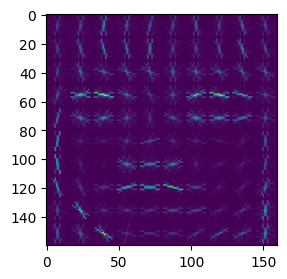

In [9]:
plt.figure(figsize=(3,3))
plt.imshow(hog_images[257])

Ja que amb el mètode HOG obtenim un vector amb moltes característiques, apliquem PCA per reduïr la dimensionalitat i així eliminar redundàncies:

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100, random_state=1)
hog_features_reduced = pca.fit_transform(hog_features)

# HOG: MODEL SELECTION AND HYPERPARAMETERS SEARCH

Dividim el nostre dataset en train i test. Lo ideal seria dividir en train, validation i test, però com no estem fent una optimització intensiva d'hiperparàmetres i el conjunt d'imatges no és molt gran, no podem permitir-nos dividir-lo més.

In [11]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
                    hog_features_reduced, labels, test_size=0.20, stratify=labels, random_state=99
                )

Provem Cross Validation amb els mètodes següents per trobar el millor:

In [12]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(random_state=42)
}

f1_scores=[]
for name, model in models.items():
    scores = cross_val_score(model, hog_features_reduced, labels, cv = StratifiedKFold(n_splits = 10, random_state=42, shuffle=True), scoring = 'accuracy')
    print(f'{name}: Accuracy en CV = {scores.mean():.4f}')

Logistic Regression: Accuracy en CV = 0.8213
SVM: Accuracy en CV = 0.8052
Random Forest: Accuracy en CV = 0.7170


Els millors models són **Logistic Regression** i **SVM**, fem hyperparameter search per trobar els millors paràmetres:

In [13]:
model = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=1), scoring='accuracy')
grid_search.fit(X_train_2, y_train_2)

print("Best Parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
test_score = best_model.score(X_test_2, y_test_2)
print("Test Accuracy:", test_score)

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.8113461538461537
Test Accuracy: 0.86


In [14]:
model2 = LogisticRegression()

param_grid2 = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'], 
    'solver': ['lbfgs', 'saga'],
    'max_iter': [400, 500]
}

grid_search2 = GridSearchCV(estimator=model2, param_grid=param_grid2, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
grid_search2.fit(X_train_2, y_train_2)

print("Best Parameters:", grid_search2.best_params_)
print("Best score:", grid_search2.best_score_)

best_model2 = grid_search2.best_estimator_
test_score2 = best_model2.score(X_test_2, y_test_2)
print("Test Accuracy:", test_score2)

Best Parameters: {'C': 10, 'max_iter': 400, 'penalty': 'l2', 'solver': 'lbfgs'}
Best score: 0.7989873417721519
Test Accuracy: 0.83


# HOG: ANÀLISI FINAL

Obtenim millors resultats amb **SVM** amb kernel=rbf, gamma=scale i C=10 així que fem la predicció amb el trian i el test complet:

In [15]:
svm_clf = SVC(kernel='rbf', gamma='scale', C= 10, random_state=42)

svm_clf.fit(X_train_2, y_train_2)
y_pred_test_2 = svm_clf.predict(X_test_2)
y_pred_train_2 = svm_clf.predict(X_train_2)

accuracy_test2 = accuracy_score(y_test_2, y_pred_test_2)
accuracy2_train2 = accuracy_score(y_train_2, y_pred_train_2)
print("Test Accuracy:", accuracy_test2)
print("Train Accuracy:", accuracy2_train2)

Test Accuracy: 0.86
Train Accuracy: 1.0


Fem CrossValidation per evaluar el rendiment en diferents particions de les dades:

In [16]:
cv = KFold(n_splits=10, random_state=42, shuffle=True)

scores = cross_val_score(svm_clf, hog_features_reduced, labels, scoring='accuracy', cv=cv)

print('SVM MEAN Accuracy: ',str(np.mean(scores)*100)[:5] + '%')
print('Standard deviation: ',str(np.std(scores)*100)[:5] + '%')

SVM MEAN Accuracy:  84.15%
Standard deviation:  3.900%


Per últim mirem la matriu de confusió per veure quines classes ha predit pitjor:

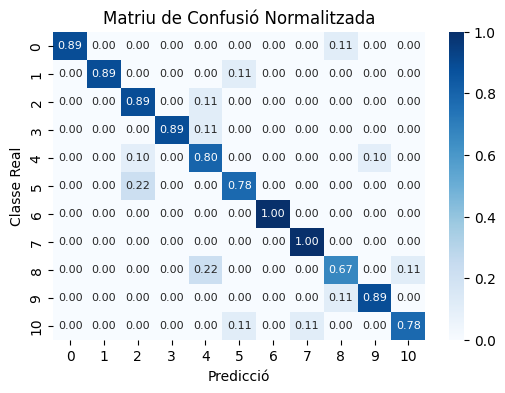

In [17]:
cm = confusion_matrix(y_test_2, y_pred_test_2, normalize='true')
plt.figure(figsize=(6, 4)) 
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", annot_kws={"size": 8}) 
plt.title("Matriu de Confusió Normalitzada")
plt.xlabel("Predicció")
plt.ylabel("Classe Real")
plt.show()

Confón a la professora McGonagall amb en Harry (0,22%) i la Hermione amb en Draco (0,22%).

# LBP

Ara provem amb els descriptors de LBP que capten les textures:

In [18]:
def compute_lbp_features(images, radius=1, n_points=8, grid_x=8, grid_y=8):
    descriptors = []
    all_histograms = []
    lbp_images = []
    for image in images:
        lbp_image = local_binary_pattern(image, n_points, radius, method="uniform")
        lbp_images.append(lbp_image)

        h, w = image.shape
        cell_h, cell_w = h // grid_y, w // grid_x
        
        descriptor_vector = []
        histograms = []

        for i in range(grid_y):
            for j in range(grid_x):
                cell = lbp_image[i * cell_h : (i + 1) * cell_h, j * cell_w : (j + 1) * cell_w]
                
                hist, _ = np.histogram ( cell.ravel(), 
                    bins=np.arange(0, n_points + 3), 
                    range=(0, n_points + 2), density=True )
                
                histograms.append(hist)
                descriptor_vector.extend(hist) 
        
        descriptors.append(np.array(descriptor_vector))
        all_histograms.append(histograms)
    
    return lbp_images, descriptors, all_histograms

radius = 2
n_points =  8 * radius
lbp_images_data, lbp_features_data, hist_data = compute_lbp_features(data_preprocessed, radius, n_points)

Observem el histograma de frequencies, que reflexa la distribució de patrons LBP en una cel·la específica d'una imatge. 
L'eix X representa els valors possibles dels patrons LBP dins de la cel·la, aquests valors (índexs) van des de 0 fins a
n_points + 2, on és el nombre de punts en el veïnatge circular utilitzat per calcular el LBP (en aquest cas, 16). L'últim valor es un patró no uniforme, que captura aquells píxels que no s'ajustan a patrons uniformes.

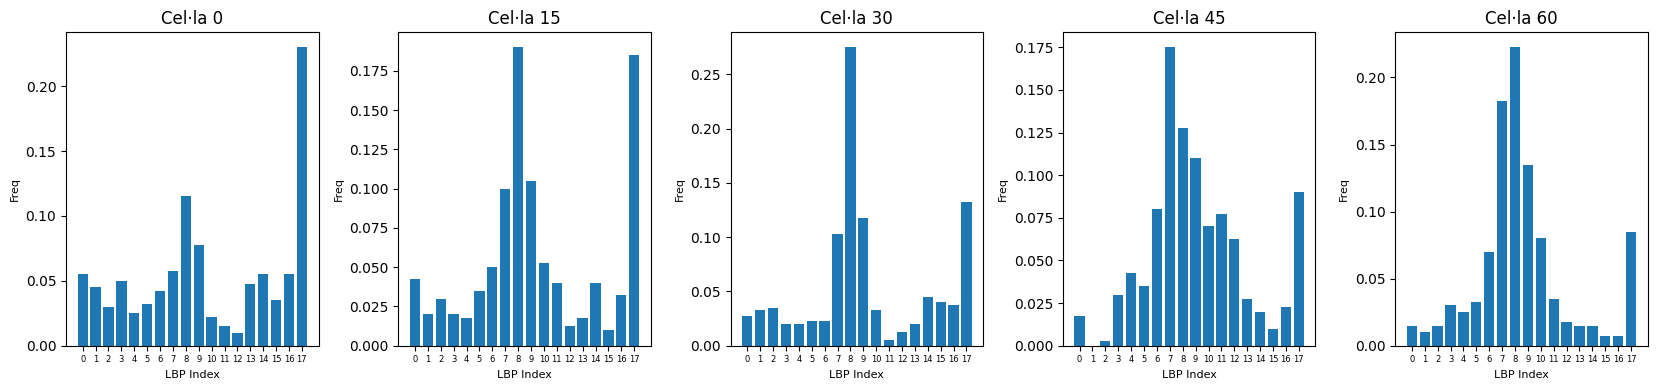

In [19]:
i=0
plt.figure(figsize=(20, 4))
for cell_index in range(0,64,15):
    plt.subplot(1, 6, i+1) 
    plt.bar(range(len(hist_data[257][cell_index])), hist_data[257][cell_index])
    plt.title(f"Cel·la {cell_index}")
    plt.xticks(range(len(hist_data[257][cell_index])), fontsize=6)
    plt.xlabel("LBP Index", fontsize=8)
    plt.ylabel("Freq", fontsize=8)
    i+=1
plt.tight_layout()
plt.show()


Per obtenir una visió global, sumem les frequencies de totes las cel·les d'una imatge per obtenir un únic histograma per imatge. Aqui, per exemple, agafem les 10 primeres imatges que corresponen al mateix personatge, Albus Dumbledore:

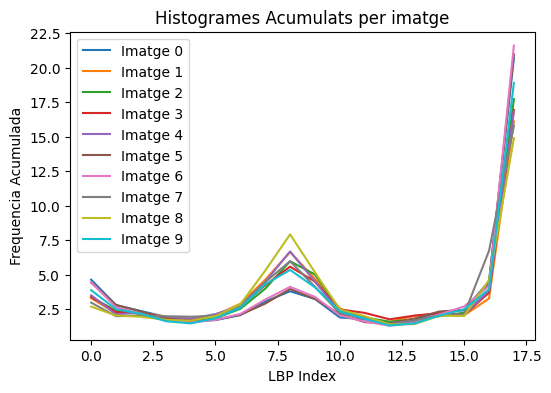

In [20]:
cumulative_histograms = []
cumulative_hist = 0
for histograms in hist_data:
    cumulative_hist = np.sum(histograms, axis=0) 
    cumulative_histograms.append(cumulative_hist)

plt.figure(figsize=(6, 4))
for i, cumulative_hist in enumerate(cumulative_histograms[:10]):
    plt.plot(range(len(cumulative_hist)), cumulative_hist, label=f"Imatge {i}")
plt.title("Histogrames Acumulats per imatge")
plt.xlabel("LBP Index")
plt.ylabel("Frequencia Acumulada")
plt.legend()
plt.show()


Text(0.5, 1.0, 'Hermione Granger')

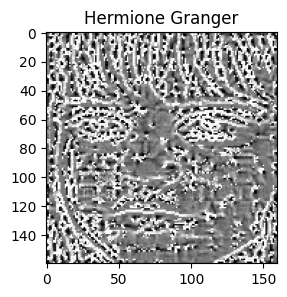

In [21]:
plt.figure(figsize=(3,3))
plt.imshow(lbp_images_data[257], cmap="gray")
plt.title(names[257])

# LBP: MODEL SELECTION AND HYPERPARAMETERS SEARCH

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
                    lbp_features_data, labels, test_size=0.20, stratify=labels, random_state=42
                )

sc = StandardScaler()
X_norm = sc.fit_transform(lbp_features_data)
X_train_norm = sc.fit_transform(X_train)
X_test_norm = sc.fit_transform(X_test)

Fem CrossValidation per trobar el millor model:

In [23]:
models_lbp = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(random_state=42)
}

for name, model in models_lbp.items():
    scores = cross_val_score(model, X_norm, labels, cv = StratifiedKFold(n_splits = 10, random_state=42, shuffle=True), scoring = 'accuracy')
    print(f'{name}: Accuracy en CV = {scores.mean():.4f}')

Logistic Regression: Accuracy en CV = 0.7048
SVM: Accuracy en CV = 0.6064
Random Forest: Accuracy en CV = 0.4738


El millor model és **Logistic Regression**, fem hyperparameter search per trobar els millors paràmetres:

In [24]:
logistic = LogisticRegression()

param_grid_lbp = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'], 
    'solver': ['lbfgs', 'saga'],
    'max_iter': [1000]
}

grid_search_lbp = GridSearchCV(estimator=logistic, param_grid=param_grid_lbp, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
grid_search_lbp.fit(X_train_norm, y_train)

print("Best Parameters:", grid_search_lbp.best_params_)
print("Best score:", grid_search_lbp.best_score_)

best_model_lbp = grid_search_lbp.best_estimator_
test_score_lbp = best_model_lbp.score(X_test_norm, y_test)
print("Test Accuracy:", test_score_lbp)

c:\Users\nerea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\nerea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\nerea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\nerea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\nerea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the 

Best Parameters: {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
Best score: 0.6682911392405064
Test Accuracy: 0.74


c:\Users\nerea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# LBP: ANÀLISI FINAL

Obtenim millors resultats amb **Logistic Regression** amb penalty=l2, solver=saga i C=10 així que fem la predicció amb el train i el test complet, amb i sense els hiperparàmetres:

In [25]:
classifier = LogisticRegression(C= 10, penalty= 'l2', solver= 'saga')
classifier2 = LogisticRegression()

sc = StandardScaler()
X_norm_train = sc.fit_transform(X_train)
X_norm_test = sc.fit_transform(X_test)

classifier.fit(X_norm_train, y_train)
y_pred_train = classifier.predict(X_norm_train)
y_pred_test = classifier.predict(X_norm_test)

acc_train = accuracy_score(y_train, y_pred_train )
acc_test = accuracy_score(y_test, y_pred_test)

print("Test Accuracy amb hiperparam:", acc_test)
print("Train Accuracy amb hiperparam:", acc_train)

classifier2.fit(X_norm_train, y_train)
y_pred_train2 = classifier2.predict(X_norm_train)
y_pred_test2 = classifier2.predict(X_norm_test)

acc_train2 = accuracy_score(y_train, y_pred_train2 )
acc_test2 = accuracy_score(y_test, y_pred_test2)

print("Test Accuracy sense hiperparam:", acc_test2)
print("Train Accuracy sense hiperparam:", acc_train2)

c:\Users\nerea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Test Accuracy amb hiperparam: 0.74
Train Accuracy amb hiperparam: 1.0
Test Accuracy sense hiperparam: 0.75
Train Accuracy sense hiperparam: 1.0


Obtenim millors resultats sense especificar els hiperparametres.

Fem CrossValidation per evaluar el rendiment en diferents particions de les dades:

In [26]:
classifier = LogisticRegression()

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
skf_scores = cross_val_score(classifier, X_norm, labels, scoring='accuracy', cv = skf)

print('LogisticRegression MEAN Accuracy: ',str(np.mean(skf_scores)*100)[:5] + '%')
print('Standard deviation: ',str(np.std(skf_scores)*100)[:5] + '%')

LogisticRegression MEAN Accuracy:  70.48%
Standard deviation:  6.325%


Per últim mirem la matriu de confusió per veure quines classes ha predit pitjor:

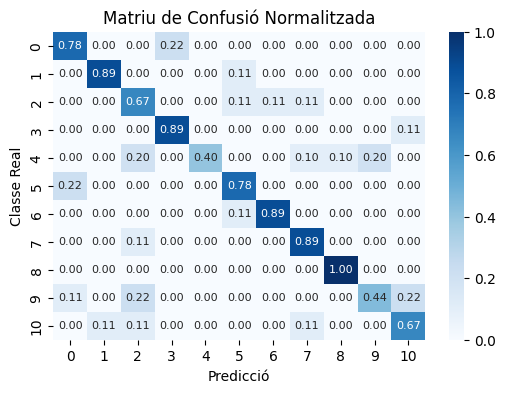

In [27]:
cm = confusion_matrix(y_test, y_pred_test2, normalize='true')
plt.figure(figsize=(6, 4)) 
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", annot_kws={"size": 8}) 
plt.title("Matriu de Confusió Normalitzada")
plt.xlabel("Predicció")
plt.ylabel("Classe Real")
plt.show()

Confón Draco amb en Ron (0,22%), Hermione amb Albus (0,22%), Albus amb Hagrid (0,22%) i Ron amb Snape (0,22%).

# PREDICCIÓ FINAL

Veiem que el millor mètode que ens funciona amb el dataset dels personatges de Harry Potter és HOG. A continuació hem construit un codi per que qualsevol persona pugui utilitzar una imatge d'un dels personatges de Harry Potter per veure si el model fa bé la predicció. Nosaltres ho provarem amb els 3 protagonistes.

In [28]:
numeros_fotos_dataset = [207, 255, 424] #aqui podeu el numero de la foto que vulgeu predir

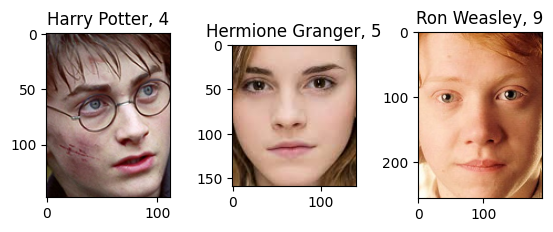

In [29]:
i=1
for c in numeros_fotos_dataset:
    plt.subplot(1, 3, i) 
    plt.imshow(data[c])
    plt.title(f'{names[c]}, {labels[c]}')
    i+=1
plt.subplots_adjust(wspace=0.5)

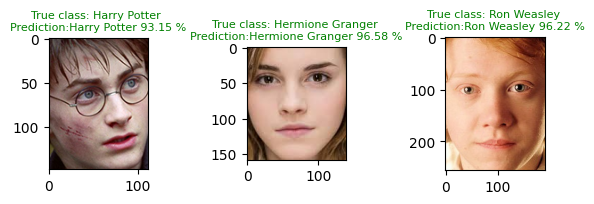

In [30]:
svm_clf = SVC(kernel='rbf', gamma='scale', C= 10, random_state=42, probability=True)
svm_clf.fit(X_train_2, y_train_2)
unique_names = list(dict.fromkeys(names))
i=1
for c in numeros_fotos_dataset:
    predict_class = svm_clf.predict(hog_features_reduced[c].reshape(1, -1))
    probs_imatge = svm_clf.predict_proba(hog_features_reduced[c].reshape(1, -1))
    prob_imatge = probs_imatge[0][labels[c]]
    name_prediction = unique_names[predict_class[0]]

    plt.subplot(1, 3, i) 
    plt.imshow(data[c])
    title = f'True class: {names[c]} \nPrediction:{name_prediction} {prob_imatge * 100:.2f} %'
    if labels[c] == predict_class[0]:
        c = 'g'
    else:
        c = 'r'
    plt.title(title,c=c)
    plt.title(title, fontsize=8)
    i+=1
plt.subplots_adjust(wspace=1)